# Задача предсказание цены съемной квартиры

## 1. Предобработка данных 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

В этом датасете содержится около 49 000 наблюдений с 16 атрибутами, и он состоит из категориальных и числовых значений.

In [6]:
df.isnull().sum() # посмотрим на то есть ли в переменных пропуски

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Удалим ненужные столбцы

In [7]:
df.drop(['name', 'host_name', 'id', 'host_id', 'last_review'], axis=1, inplace=True)

In [8]:
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


Заменим значения NaN в столбце reviews_per_month на 0.

In [9]:
df.fillna({'reviews_per_month':0}, inplace=True)
df.reviews_per_month.isnull().sum() #проверим изменения

0

Изучим непрерывные переменные

In [10]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Посмотрим как выглядит распределение цен.

Удалим для начала строки с нулевым значением цены.

In [11]:
df = df[df['price'] >= 1]

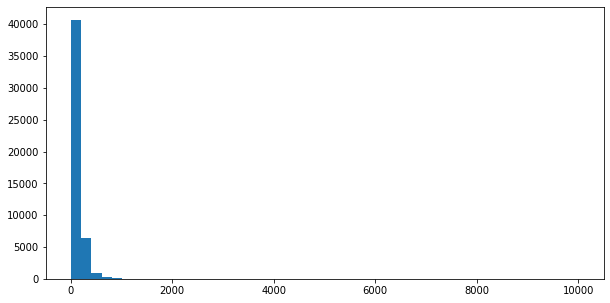

In [12]:
df.price.hist(bins=50, grid=False, figsize=(10,5))

У распределения цен есть проблема - очень длинный хвост. В выборке встречаются квартиры с довольно большой стоимостью. Такие наблюдения называются выбросами. С ними нужно бороться, иначе наша модель подстроится под них. Давайте сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной.

In [13]:
airbnb = df.copy()

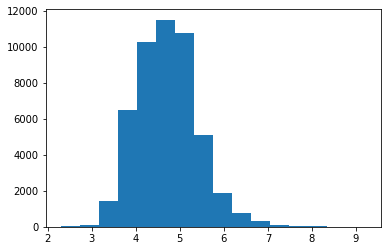

In [14]:
airbnb['price'] = np.log(airbnb['price'])
airbnb.price.hist(bins=16, grid=False)

Cгладили распределение цен, прологарифмировав его.

Посмотрим на матрицу корреляций.

Еще разпроверим пропущенные значения

In [15]:
airbnb.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

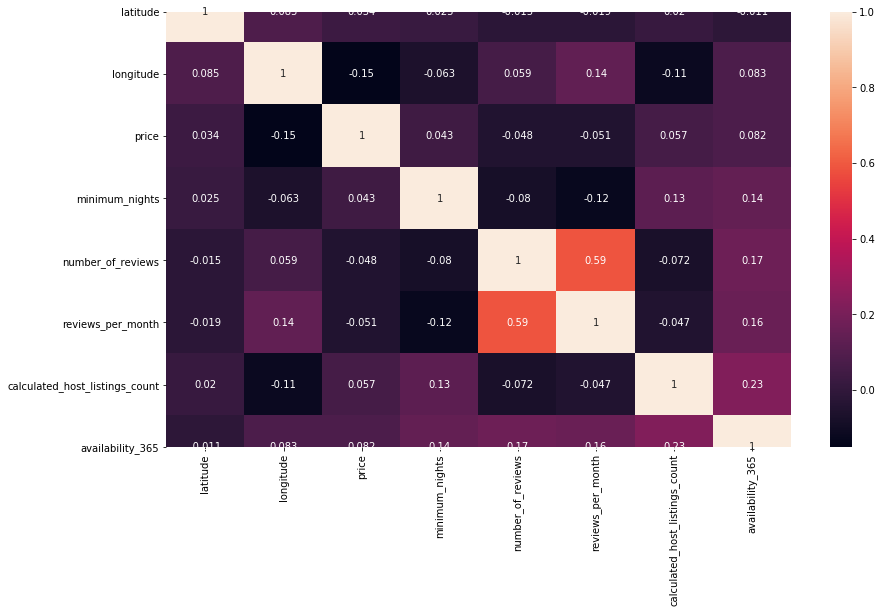

In [16]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True);

In [17]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

Text(0.5, 1.0, 'Neighbourhood Group')

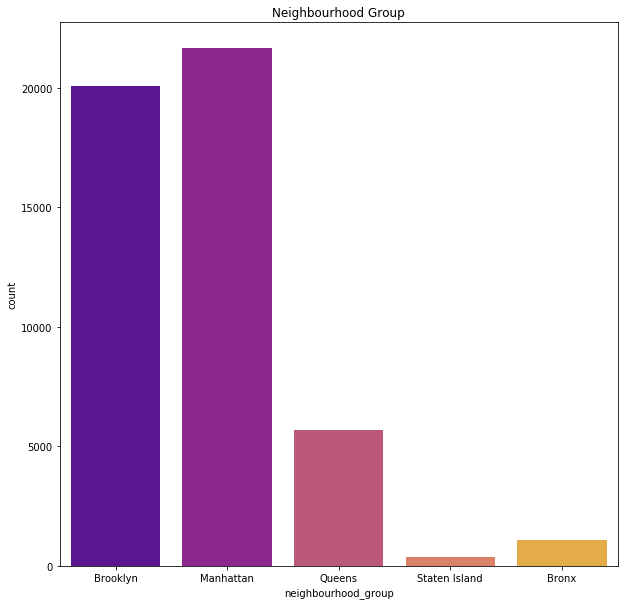

In [18]:
sns.countplot(df['neighbourhood_group'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Neighbourhood Group')

In [19]:
df['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

Text(0.5, 1.0, 'Neighbourhood')

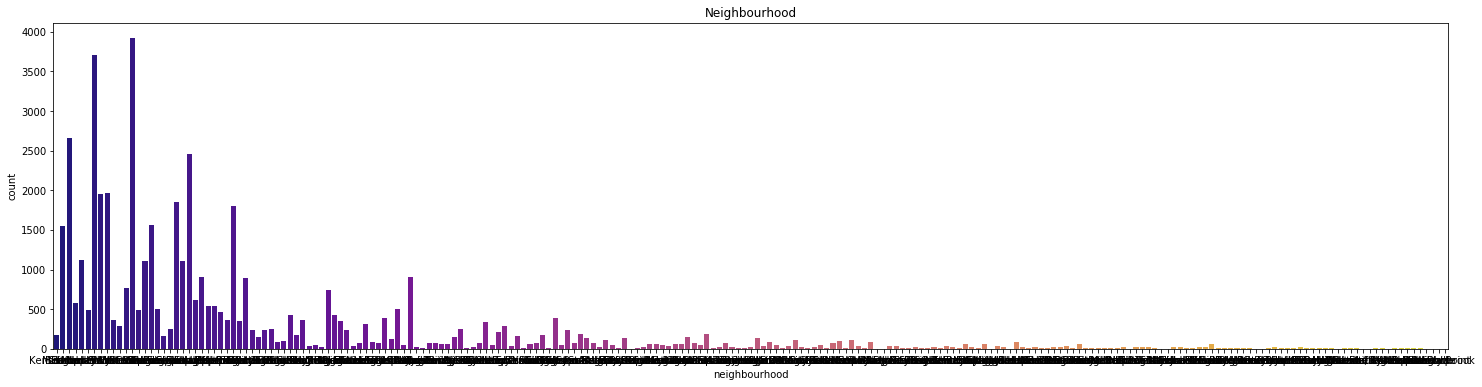

In [20]:
sns.countplot(df['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(25,6)
plt.title('Neighbourhood')

In [21]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

Text(0.5, 1.0, 'room_type')

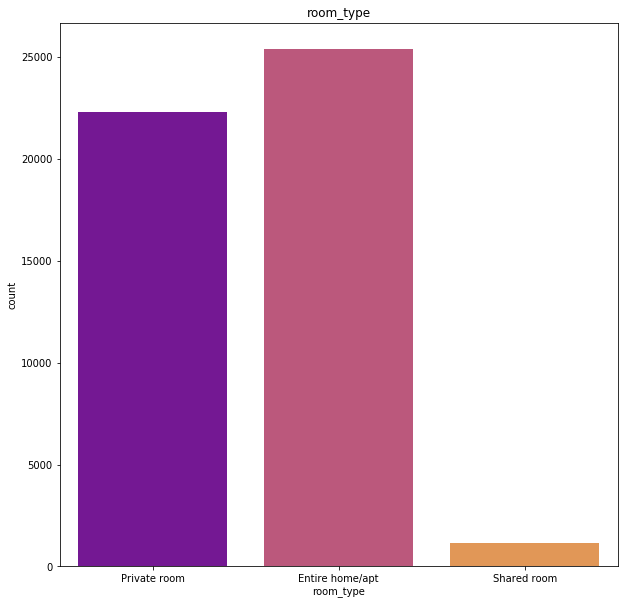

In [22]:
sns.countplot(df['room_type'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('room_type')

Связь между атрибутами neighbourhood_group и availability_365

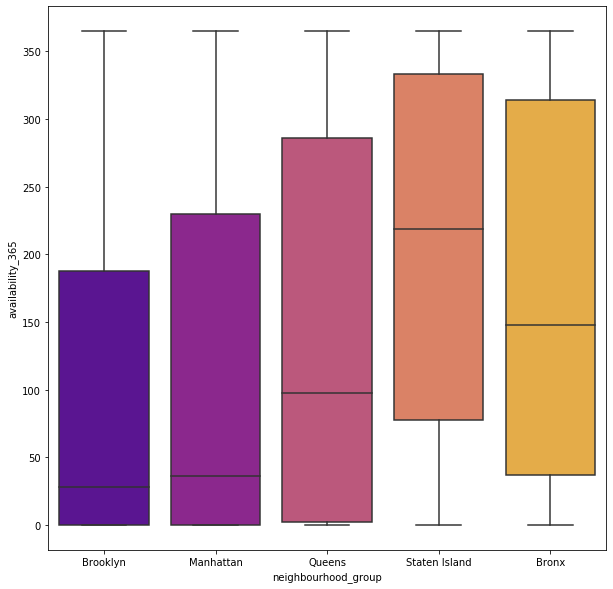

In [23]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df, x='neighbourhood_group',y='availability_365',palette='plasma')

Карта Neighbourhood group

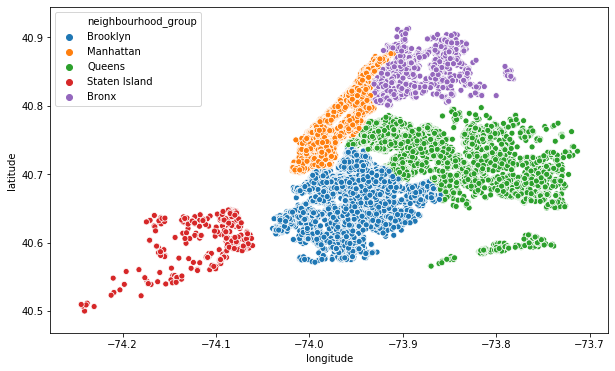

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.neighbourhood_group)
plt.ioff()

Карта по room_type

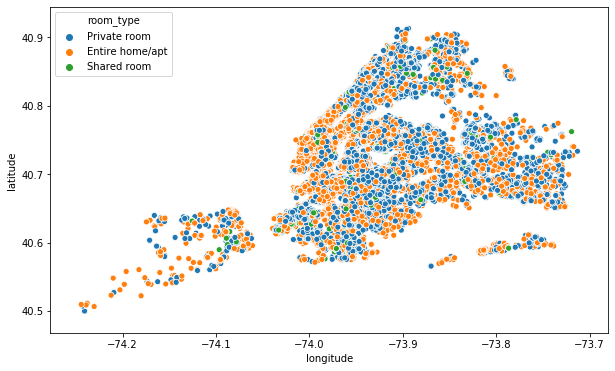

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(df.longitude,df.latitude,hue=df.room_type)
plt.ioff()

Взгляним на распределение price

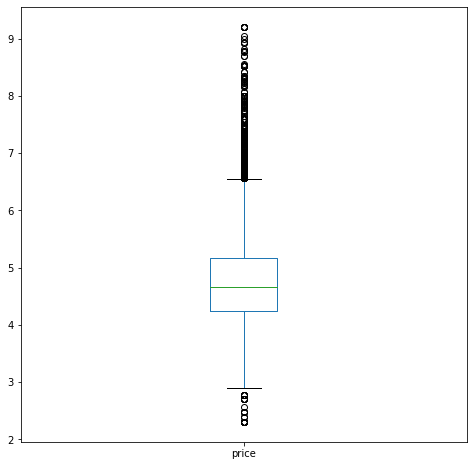

In [26]:
airbnb.price.plot.box(figsize=(8,8))

Займёмся предобработкой категориальных переменных при помощи одного горячего кодирования (One Hot Encoding). При таком преобразовании категориальной переменной мы создаем столько новых столбцов, сколько различных значений этой переменной у нас было. Обычно, при этом, первый столбец убирается, чтобы не создавать линейно-зависимых столбцов. 

In [27]:
df_neighbourhood_group = pd.get_dummies(airbnb['neighbourhood_group'], drop_first=True, prefix='n_group')

In [28]:
df_neighbourhood = pd.get_dummies(airbnb['neighbourhood'], drop_first=True, prefix='neighbourhood')

In [29]:
df_room_type = pd.get_dummies(airbnb['room_type'], drop_first=True, prefix='room_type')

Создали отдельные таблицы для каткгориальных переменных

In [30]:
airbnb = pd.concat([airbnb.drop(['neighbourhood_group', 'neighbourhood', 'room_type'], axis=1), df_neighbourhood_group, df_neighbourhood, df_room_type], axis=1)

Объединили назад все наши таблички

In [31]:
airbnb.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,n_group_Brooklyn,n_group_Manhattan,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.003946,1,9,0.21,6,365,1,0,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,5.416100,1,45,0.38,2,355,0,1,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,5.010635,3,0,0.00,1,365,0,1,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,4.488636,1,270,4.64,1,194,1,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,4.382027,10,9,0.10,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Делим данные на тренировочные и тестовые!  30%  данных откладываем для тестирования качества модели. Остальные  70%  берём для обучения.

In [32]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(airbnb, test_size = 0.3)

Сделаем шкалирование всех непрерывных переменных

In [33]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']])

In [35]:
# Заменяем значения на отскалированные
df_train[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = df_train_scale
df_test[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = df_test_scale

Все непрерывные переменные теперь выглядят проскалированными

In [36]:
df_train.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,n_group_Brooklyn,n_group_Manhattan,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
201,-0.247926,1.598488,5.579730,-0.001591,0.333368,-0.451214,-0.067655,1.909636,0,0,...,0,0,0,0,0,0,0,0,0,0
25679,0.889082,-0.185726,5.703782,-0.308527,-0.524364,-0.692206,-0.187879,-0.858914,0,1,...,0,0,0,0,0,0,0,0,0,0
41422,-0.397532,-1.269899,5.365976,-0.257371,-0.276073,1.337197,9.610420,1.507628,0,1,...,0,0,0,0,0,0,0,0,0,0
31202,0.296531,-0.588760,4.394449,-0.155059,-0.388932,-0.444872,-0.157823,-0.858914,0,1,...,0,0,0,0,0,0,0,0,1,0
4413,-0.593030,0.426539,4.077537,0.663439,-0.163214,-0.514633,-0.187879,-0.449320,1,0,...,0,0,0,0,0,0,0,0,1,0


Посмотрим на размеры трэйна и теста

In [37]:
print(df_train.shape)
print(df_test.shape)

(34218, 234)
(14666, 234)


Разделим цены и параметры квартир по разным переменным для удобства

In [38]:
y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).get_values()
X_test = df_test.drop('price', axis=1).get_values()

## 2. Константный прогноз

Построим константный прогноз. Будем говорить, что стоимость любой квартиры равна среднему значению. Мы будм сравнивать с ним прогнозы более сложных моделей.

In [39]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([4.72860055, 4.72860055, 4.72860055, 4.72860055, 4.72860055])

## 3. Метрики качества для регрессии

Посмотрим на несколько метрик качества.

In [40]:
from sklearn import metrics  # подгружаем метрики

Первой метрикой, будет MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что квартира стоит 20 рублей, а она стоила 10 рублей, мы ошиблись на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это средняя сумма рублей, на которую мы облажались. 

In [41]:
metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_naive))

83.81258967033287

Второй метрикой является MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 долларов, то в ошибку войдёт 25. Если мы ошиблись на 10 долларов, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

In [42]:
metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive))

58221.80688081636

Получим новую ошибку - RMSE, считается как корень из MSE.

In [43]:
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred_naive)))

241.29195361805242


Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.



In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred_naive)

11.897246585256088

Средня ошибка примерно на 12% от цены.


Еще одна метрика, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков.

In [45]:
metrics.r2_score(y_test, y_pred_naive)

-5.661618210051067e-05

Закинем все метрики в одну общую функцию, чтобы было удобно их печатать.

In [46]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [47]:
print_metrics(y_test, y_pred_naive)

MAE: 83.81258967033287
RMSE: 241.29195361805242
R2: -5.661618210051067e-05
MAPE: 11.897246585256088


## 3. Строим первую регрессию

Модель линейная регрессия говорит, что цена на квартиру формируется в результате суммирования тех характеристик, которыми она обладает с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ price = 10000 + 20 \cdot totsp,$$

то это означает, что средняя стоимость квартиры равна 10 тыс. долларам. При этом каждый дополнительный метр общей площади квартиры делает её дороже на 20 рублей. 

Для того, чтобы обучить регрессию минимизируют одну из метрик ошибок. В базовой комплектации регрессии это делают с MSE. 

In [48]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на ошибку

In [87]:
metrics.mean_squared_error(y_test,y_pred_regr)

3.9416648693786104e+16

Посмотрим на то, какие признаки вносят в цену наибольший вклад.

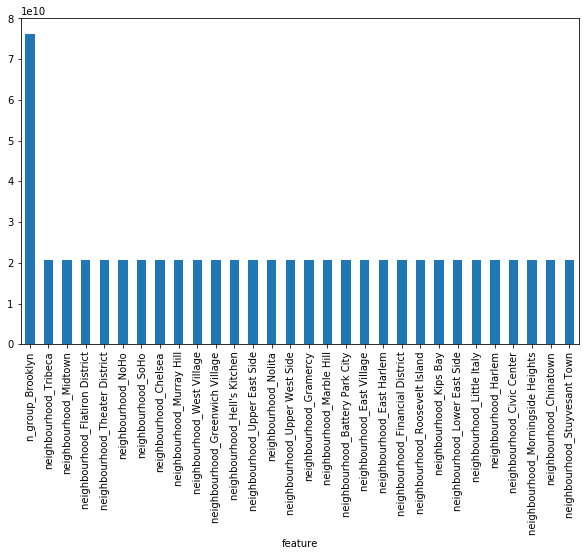

In [88]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"][:30].plot('bar', figsize=(10, 6));

## 4. Строим Lasso-регрессию

Построим более сложную модель, LASSO-регрейссию. Фишка этой модели в том, что она зануляет лишние коэффиценты.

In [89]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

Посмотрим на важность факторов для стоимости квартиры.

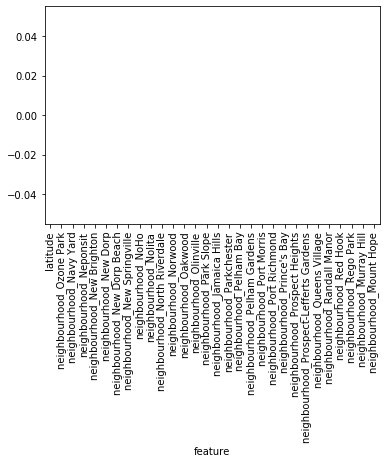

In [90]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"][:30].plot('bar');

In [91]:
print_metrics(y_test,y_pred_lasso)

MAE: 83.81258967033328
RMSE: 241.29195361805125
R2: -5.661618210206498e-05
MAPE: 11.897246585256326


Важных факторов нет, всё занулилось. Метрики качества такие же, как при константном прогнозе. Дело в том, что у модели есть гиперпараметр - сила зануления. И его нужно подбирать методом перебора. В нашей модели он стоял слишком большим. Попробуем подобрать этот параметр.

## 5. Подбор гиперпараметра для Lasso-регрессии

Будем делать перебор следующим способом: дробим тренировочную выборку на пять частей. На четырёх учим модель, на пятой прогнозируем. Смотрим на качество. И так по очереди выделяем для прогноза каждую из 5 частичек. Потом качество прогноза усредняем - кросс-валидация. Для какого параметра из решётки качетство получится наибольшим, тот мы и оставим.

In [92]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


При параметре 0.001 качество у прогнозов получилось самым хорошим. Его и берём. Посмотрим на важность переменных

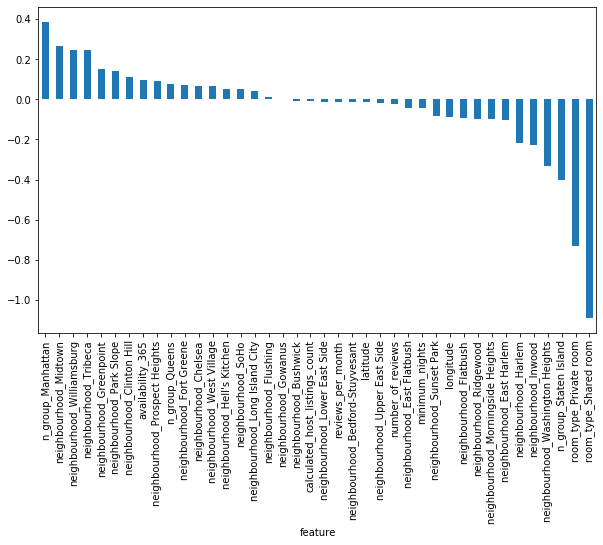

In [93]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance_non_zero = featureImportance[featureImportance["importance"] != 0]
featureImportance_non_zero["importance"].plot('bar', figsize=(10, 6));

И на качество модели. Оно оказывается близким к обычной регрессии. Судя по всему у нас в выборке нет лишних переменных и занулять нечего.

In [94]:
print_metrics(y_test,y_pred_lasso)

MAE: 61.675338392863594
RMSE: 226.0092859394042
R2: 0.5163305519736889
MAPE: 7.347831199572035


In [95]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.00022831618343447586


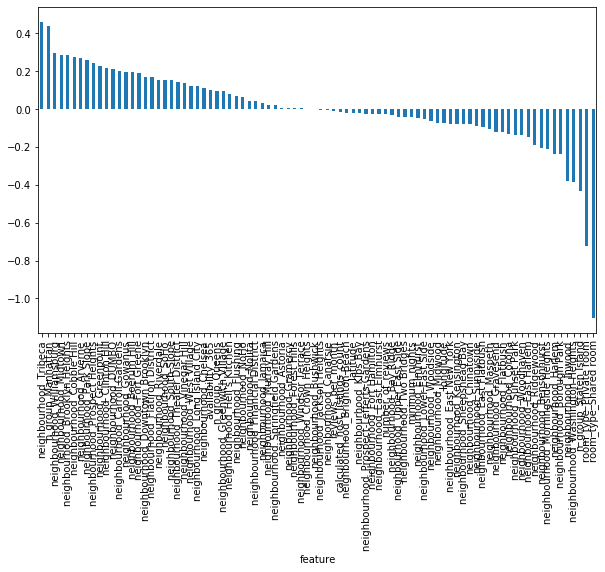

In [96]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance_non_zero = featureImportance[featureImportance["importance"] != 0]
featureImportance_non_zero["importance"].plot('bar', figsize=(10, 6));

In [97]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 61.21428893990083
RMSE: 225.28461517777362
R2: 0.5275594342489363
MAPE: 7.241442047138183


## 4. Строим Ridge-регрессию

In [98]:
from sklearn.linear_model import RidgeCV

# Объявили модель 
ridge_cv = RidgeCV(cv=5)

# Объявили перебор 
ridge_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', ridge_cv.alpha_)

# Сделали прогнозы
y_pred_ridge_cv = ridge_cv.predict(X_test)

Лучшее значение параметра: 1.0


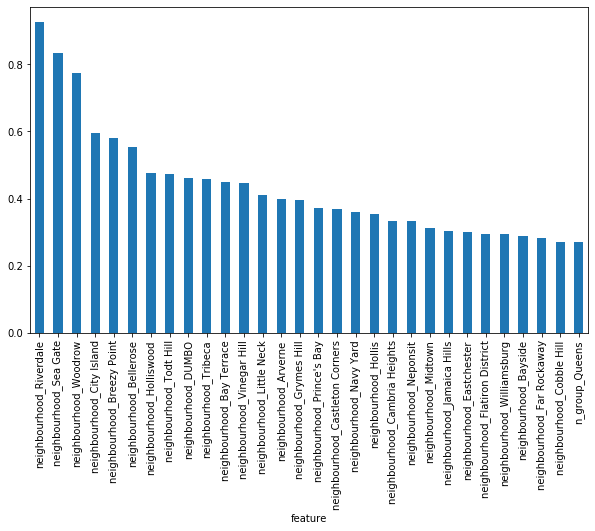

In [99]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance_non_zero = featureImportance[featureImportance["importance"] != 0]
featureImportance_non_zero["importance"][:30].plot('bar', figsize=(10, 6));

In [100]:
print_metrics(y_test, y_pred_ridge_cv)

MAE: 61.223119950942305
RMSE: 224.9361319514842
R2: 0.5298941436211242
MAPE: 7.226211012887389


Точность незначительно увеличилась.

## 5. Строим ElasticNet-регрессию

In [101]:
from sklearn.linear_model import ElasticNetCV

# Объявили модель 
elasticnet_cv = ElasticNetCV(cv=5)

# Объявили перебор 
elasticnet_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', ridge_cv.alpha_)

# Сделали прогнозы
y_pred_elasticnet_cv = elasticnet_cv.predict(X_test)

Лучшее значение параметра: 1.0


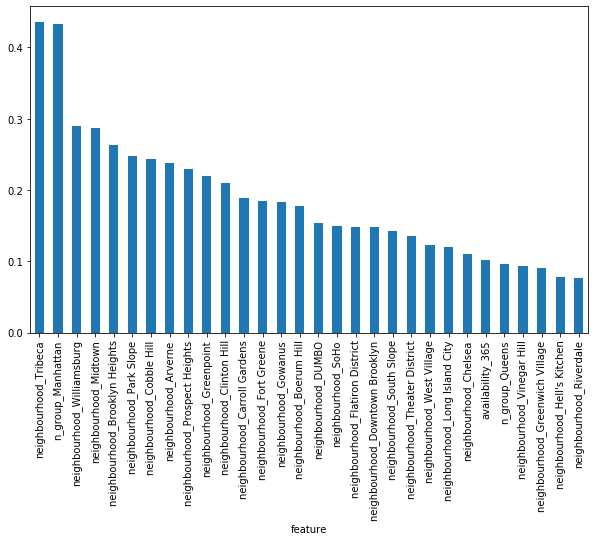

In [102]:
featureImportance = pd.DataFrame({"feature": airbnb.drop('price',axis=1).columns, 
                                  "importance": elasticnet_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance_non_zero = featureImportance[featureImportance["importance"] != 0]
featureImportance_non_zero["importance"][:30].plot('bar', figsize=(10, 6));

In [103]:
print_metrics(y_test, y_pred_elasticnet_cv)

MAE: 61.21547049891026
RMSE: 225.3450751595527
R2: 0.5272550881134204
MAPE: 7.2449439064669825


Все три метода регуляризации показали примерно одинаковую точность: MAE: 60, RMSE: 209